In [2]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from math import pi
import orbithunter as orb
import inspect
import orbithunter.ks as ks
import h5py
import time
from matplotlib import gridspec
import pandas as pd

# Covering space-time, an investigation.


# Table of contents
<a id='toc'></a>

## [A. Function declarations](#func)

## [B. Glossary](#glossary)

## [1. Introduction](#intro)

## [2. Family overlap](#family)

## [3. Group orbit overlap](#grouporbit)
    
## [4. Minimal covers](#minimal)

###  [4.a fundamental_domain==False](#minimal0)
###  [4.b fundamental_domain==True](#minimal1)

## [5. Current difficulties](#results)


<a id='func'></a>
# A. Function declarations.
Some of these are deprecated; work in progress

In [3]:
def minimal_covering_set(covering, cover_threshold=0.99, verbose=True, dtype=int):
    """ Find the smallest number of masks which cover a specified proportion of the total cover area."""
    assert cover_threshold < 1, 'cover threshold must be provided as a float between (0, 1).'
    total_mask = covering.any(axis=0)
    area_covered = total_mask.astype(bool).sum()
    # Find the orbit mask with the largest covering.
    sites_covered = covering.sum(axis=tuple(range(1, len(covering.shape))))
    minimal_indices = []
    max_area_cover_index = np.argmin(sites_covered)
    minimal_cover_mask_indices = np.zeros(covering.shape[0], dtype=bool)
    minimal_cover_mask_indices[max_area_cover_index] = True
    cover_percentage = covering[minimal_cover_mask_indices, ...].any(axis=0).astype(bool).sum() / total_mask.astype(bool).sum()
    # If the cover percentage is less than the provided threshold, then look for more masks to add.
    
    if verbose:
        print(sum(minimal_cover_mask_indices), cover_percentage)
    percentages = []
    percentages.append(cover_percentage)
    while cover_percentage < cover_threshold:
        # the next mask best mask is the one which covers the most area not covered by the current mask. 
        orthogonalities = []
        # The current union of masks included
        minimal_cover = covering[minimal_cover_mask_indices, ...].any(axis=0)
        # The current masks not included. 
        complement_cover = covering[np.invert(minimal_cover_mask_indices), ...]
        # Use broadcasting to get the intersection with each excluded mask.
        currently_uncovered = (complement_cover & ~minimal_cover)
        # Find the next best mask to add by totaling the number of points it covers which are not in minimal cover yet. 
        next_greatest_contribution = np.argmax(currently_uncovered.sum(axis=tuple(range(1, len(covering.base.shape)+1))))
        # demarcate the newer member of the cover. 
        minimal_cover_mask_indices[next_greatest_contribution] = True
        

        # Calculate the amount of area covered with inclusion of the next mask. 
        cover_percentage = (covering[minimal_cover_mask_indices, ...].astype(bool).any(axis=0).sum() 
                            / total_mask.astype(bool).sum())
        percentages.append(cover_percentage)
        if verbose:
            print(sum(minimal_cover_mask_indices), cover_percentage)
    return minimal_cover_mask_indices, percentages

In [4]:
def plot_covering_families(covering, base, windows, verbose=True, figsize=(6,6)):
    """ Given a covering, plot its constituents or plot its union, w"""

    covering_percentages = []
    for mask_key in covering:
        if covering[mask_key].shape != base.shape:
            covering_mask = scanning_mask(covering[mask_key], base, windows[int(mask_key)], strides)
        else:
            covering_mask = covering[mask_key]
        bool_mask = covering_mask.astype(bool).copy()
        bool_mask[bool_mask!=0]=1
        covering_percentage = covering_mask.astype(bool).sum()/covering_mask.size
        print('{}% space-time covered by orbit {}'.format(100*covering_percentage, mask_key))
        fig = plt.figure(figsize=figsize) 
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5]) 
        ax0 = plt.subplot(gs[0])
        ax0.imshow(windows[int(mask_key)].state, cmap='jet')
        ax1 = plt.subplot(gs[1])
        im = ax1.imshow(np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool))), cmap='jet')
        _ = plt.show()
        _ = plt.close()
        print('##############')
        
def plot_covering_union(covering, base, windows, strides=(1,1), verbose=True, figsize=(6,6)):
        covering_mask = covering_union(covering, base, windows, strides)
        bool_mask = covering_mask.astype(bool).copy()
        bool_mask[bool_mask!=0]=1
#         base.plot(figsize=figsize)
#         base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
#                                      basis='field', parameters=base.parameters).plot(figsize=figsize)
        base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                                     basis='field', parameters=base.parameters).plot(figsize=figsize)

In [5]:
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, widgets
# import plotly.graph_objs as go
import plotly.offline as py
import chart_studio.plotly as plotly
import seaborn as sns
import mpl_toolkits.mplot3d.art3d as art3d
from plotly.graph_objects import *
import matplotlib.pyplot as plt 
from matplotlib import gridspec

In [36]:
invert=True
def interactwrapper(orbit_cover_instance, trimmed_scores=None, mapped_scores=None, **kwargs):
    mindex = kwargs.get('mindex', 0)
    maxdex = kwargs.get('maxdex', len(orbit_cover_instance.windows)-1)
    windows = orbit_cover_instance.windows
    if trimmed_scores is None:
        trimmed_scores = orbit_cover_instance.trim()
    if mapped_scores is None:
        mapped_scores = orbit_cover_instance.map()
        

    def update(orbit_index):
        nonlocal trimmed_scores
        nonlocal mapped_scores
        nonlocal windows
        scores = trimmed_scores[orbit_index]
        vmin = scores.min()
        vmax = scores[scores!=np.inf].max()
        fig = plt.figure(figsize=(20,20)) 
        gs = gridspec.GridSpec(3, 3, width_ratios=[20, 1, 20], height_ratios=[20, 1, 20]) 

        ax0 = plt.subplot(gs[:, 0])
        ax1 = plt.subplot(gs[:, 1])    
        ax2 = plt.subplot(gs[:, 2])
        ax1.imshow(windows[orbit_index].state, cmap='jet')

        invalid_masked = np.ma.masked_invalid(mapped_scores[orbit_index])
        masked_base = np.ma.masked_array(orbit_cover_instance.base.state, mask=invalid_masked.mask)
        im1 = ax0.imshow(scores, vmin=vmin, vmax=vmax, cmap='viridis')
        im2 = ax2.imshow(masked_base, cmap='jet')
        ax1.axis('off')
        ax0.set_xticklabels('')
        ax0.set_yticklabels('')
        ax2.set_xticklabels('')
        ax2.set_yticklabels('')
        fig.colorbar(im2, ax=ax2, shrink=0.3)
        fig.colorbar(im1, ax=ax0, shrink=0.3)
        plt.show()
    interact(update, orbit_index=widgets.IntSlider(min=mindex, max=maxdex, step=1, value=0));

<a id='glossary'></a>
# B. Glossary.


**Covering orbits** : The set of orbits whose shadowing constitutes the cover. 

**Cover** : The regions of space-time detected as shadowing of a set of periodic orbits, called the covering orbits.

**Minimal covering orbits** : A subset of the covering orbits which reproduces a certain proportion of the cover. 

**Minimal cover**: The space-time shadowed by the orbits in the minimal covering set. 

**Family**: A collection of orbits which are all related by continuation

**Group orbit**: The collection of equivariant orbits populated by applying symmetry operations to a single orbit, i.e. a single representative of a family. 

**[Return to table of contents](#toc)**

<a id='intro'></a>
# Introduction

With results from ```continuation.ipynb```, ```shadowing.ipynb``` and ```shadowing_statistics.ipynb``` we can begin to test the covering process. Even in the context of the "family" method for calculating covering, if the number of group orbit members for each family member in the covering is large, the computations for a single family on a single domain can take a *very* long time. Therefore, it behooves us to determine a subset of group orbit members which provide the most efficient covering, in terms of computational time per area. The idea here being that more orbit family members likely only contribute to overlaps. 

So, the main objective before beginning the full covering computations (i.e. determining the area proportions and statistical averages) is to first work through the following list of tasks:

    1. Determine an efficient number of members per family to use for covering
    2. Determine an efficient number of group members per family member to use for covering
    4. Determine how the different metrics affect these results 

The different metrics mentioned in this list include the $L_2$ norm of the difference between windows $|u-v|$, the "amplitude difference" $u^2-v^2$, and the bottleneck distance between persistence diagrams. Due to the pointwise nature of the first two metrics, it is likely that these will require many more group orbit members and family members than the bottleneck distance metric, which is topological in nature. While important, this last task of determining the best metric is covered only very briefly 

In [7]:
# patch_samples = orb.read_h5("./data/large_patches.h5", tuple(str(i)+'/' for i in list(range(1001))[::10]))

In [92]:
large_patch = orb.read_h5('./data/large_patches.h5', '5/')


windows = [x.transform(to='field') for x in orb.read_h5('./data/minimal_cover.h5')]
base = orb.read_h5('./data/small_patches.h5', '0')
base.plot()
strides=(1,1)
fundamental_windows = tuple([x.to_fundamental_domain() for x in windows])

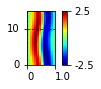

In [86]:
fundamental_windows[-1][0].plot()

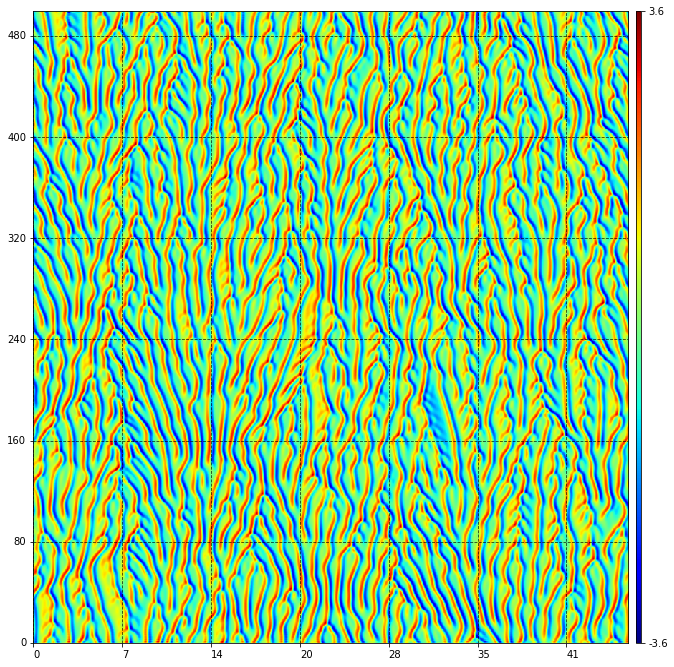

In [93]:
large_patch.plot()

Import critical values; the specificity of each key is somewhat annoying but it is not worth the effort of making this better. 

In [10]:
scores = []
fname = ['defect', 'large_defect', 'drifter', 'wiggle']
with h5py.File('all_scores.h5', 'r') as file:
    for name in fname:
        scores.append(file[name][...])

In [11]:
fundamental_windows = [list(x.group_orbit(fundamental_domain=True)) for x in windows]
thresholds = [np.quantile(x, 0.0001) for x in scores]
window_thresholds = [len(f)*[t] for f, t in zip(fundamental_windows, thresholds)]
defect = fundamental_windows[0]
defect_thresholds = window_thresholds[0]

1000 large integrated trajectories and the entirety of a group orbit were used to generate a large amount of data; the
scores evaluated at a small subset of space-time points amongst these base orbits.

In [65]:
scores = np.zeros([2048, 894, 894])
with h5py.File('cover_scores.h5', 'r') as file:
    for i in range(2048):
        scores[i, :, :] = file['defect'][str(i)][...].reshape(894, 894)

# Defect covering

Compute the L2 norm with mean flow correction density metric across spacetime for the entirety of the defect group orbit,
see how much of space time is covered.

In [16]:
defect_cover = orb.OrbitCover(large_patch,
                     defect,
                     defect_thresholds,
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    )
defect_cover.scores = scores

t0ad=time.time_ns()/10**9
defect_cover = orb.cover(defect_cover, verbose=True)
t1ad=time.time_ns()/10**9
print('\nL2 metric covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

In [ ]:
# with h5py.File('cover_scores.h5', 'a') as file:
#     fgroup = file.create_group('defect')
#     for i, metric_scrs in enumerate(defect_cover.scores):
#         file['defect'].create_dataset(str(i), data=metric_scrs.ravel())

In [18]:
detections = (defect_cover.scores <= defect_cover.thresholds).sum(axis=(1,2))

In [33]:
hundred_most_detected = np.argsort(detections)[-100:]
hundred_most_detected_scores = defect_cover.scores[hundred_most_detected, ...]

mask = (defect_cover.scores <= defect_cover.thresholds.reshape(-1, 1, 1))

new_cover = orb.OrbitCover(large_patch,
                     np.array(defect)[hundred_most_detected],
                     np.array(defect_thresholds)[hundred_most_detected],
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    mask=~mask.any(axis=0)
                    )

new_cover.scores = defect_cover.scores[hundred_most_detected]
# new_cover.padded_orbit = _pad_orbit(large_patch, new_cover.hull, new_cover.periodicity)

top100_map = new_cover.map()

top100_trim = new_cover.trim()


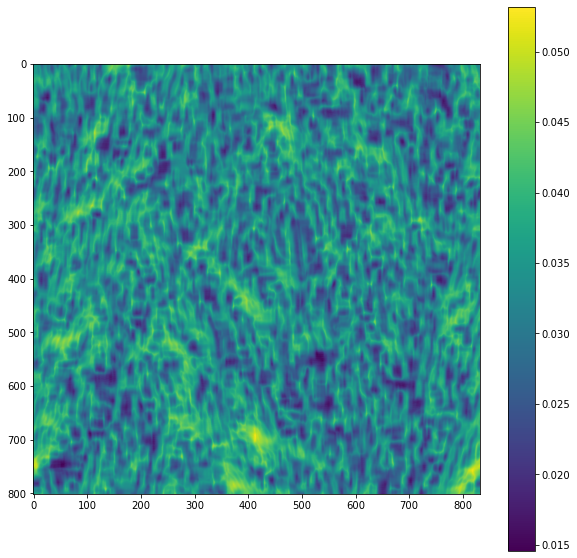

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(defect_cover.trim().min(axis=0))
plt.colorbar()
plt.show()

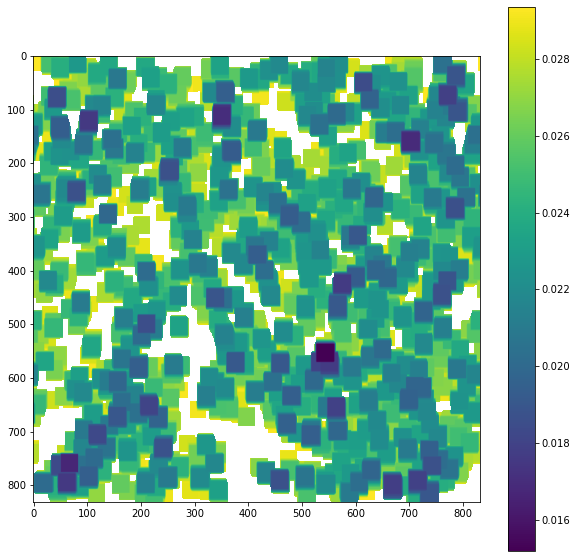

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(testmap.min(axis=0))
plt.colorbar()
plt.show()

In [37]:
interactwrapper(new_cover, trimmed_scores=top100_trim, mapped_scores=top100_map)

interactive(children=(IntSlider(value=0, description='orbit_index', max=99), Output()), _dom_classes=('widget-…

In [ ]:
defect_cover = orb.OrbitCover(large_patch,
                     defect,
                     defect_thresholds,
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    )
defect_cover.scores = scores

t0ad=time.time_ns()/10**9
defect_cover = orb.cover(defect_cover, verbose=True)
t1ad=time.time_ns()/10**9
print('\nL2 metric covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

In [19]:
defect_cover = orb.OrbitCover(large_patch,
                     defect,
                     defect_thresholds,
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    )
defect_cover.scores = scores

t0ad=time.time_ns()/10**9
defect_cover = orb.cover(defect_cover, verbose=True)
t1ad=time.time_ns()/10**9
print('\nL2 metric covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

In [ ]:
defect_cover = orb.OrbitCover(large_patch,
                     defect,
                     defect_thresholds,
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    )
defect_cover.scores = scores

t0ad=time.time_ns()/10**9
defect_cover = orb.cover(defect_cover, verbose=True)
t1ad=time.time_ns()/10**9
print('\nL2 metric covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

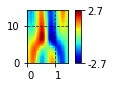

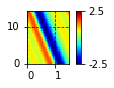

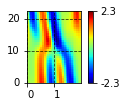

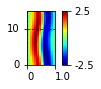

In [11]:
for x in fundamental_windows:
    x.plot()

[Return to table of contents](#toc)
# Preliminary testing

As a preliminary trial, run the covering routine with only a small set of covering orbits, not accounting for their
symmetry group orbits or continuous families. This will give an idea as to whether it will be possible to cover the space. Each fundamental orbit has a discretization of (32, 32) even though they do not have the same dimensions; simply for uniformity. however rectangular and different discretization sizes in a single ```cover``` function are allowed if replacement=True. I thought that I could improve performance by caching values during the persistent homology calculations but when the number of values in memory gets too large it actually becomes faster to recompute rather than search for values in an array. 

This calculation is "with replacement". No replacement means that once a detection has been made at a site, it will be skipped over for future orbits in the covering set. This is a cumulative process which reduces the numbers of computations for each successive orbit. The motivation being that a region of space-time only shadows a single orbit at a time, by definition. 
However, because we actually want to look at the overlaps that occur, replacement will be left on.

Overlaps are good and bad, depending on the context. They are bad when overlaps occur between different families, as the area which "belongs" to each family becomes undefined. Overlaps are good when they occur with respect to members of the same family and group orbits; this is an indication that the number of covering orbits can be reduced, because the information they provide is redundant. 


#### Metric comparison

First, with a small patch, check the performance of the different metrics as a simple guide for which one to use for the preliminary testing. First, use  bottleneck distance between persistence diagrams. This requires a custom input for the
scoring function; it must take base_slice, window orbits as its arguments, keyword arguments are allowed and it is
highly recommended that computations which are relatively expensive and only need to be computed once (i.e. the metric
is not pointwise) can be included using the ```window_cache``` keyword argument. To use ```window_cache```, a function
which computes this quantity ```window_caching_function``` must be supplied to ```cover```.

We can visualize one of these minima via surface plots, shown are two different views of the same minimum. The logarithm of the scores are plotted. Because the solutions exist in continuous families and are only ever realized with discrete approximations,
the best we can hope for is the correct scaling; that is, exponential decrease in the scoring metric as the shadowing
region and window become more aligned. 

[Return to table of contents](#toc)
# Methodology 

Plot the entire covering, both factorized and the union, and then compare with the "minimal" cover. Which
computes the subset of elements which cover at least a user specified percentage of the *covered* area. **NOT** the total area,
as clearly for "bad" covers this threshold may be unobtainable. If the cover threshold is too strict, then it is likely
that the minimal covering set will be the entire cover; something to keep in mind.

[Return to table of contents](#toc)
<a id='family'></a>
## Overlap between subsampling of a single family. 

Calculate the covers with respect to the 149 different orbits in the large defect family; this takes approximately an hour and a half and so the covers are saved for later use. This uses a large trajectory, produced by time integration, which actually has spatial periodicity. While this takes an exceptional amount of time compared to the smaller base orbits, I believe it is necessary to get an accurate depiction of the number of overlaps. Additionally, the strictest tolerance is used, meaning that detections are expected 0.01% of the time, based on the previously computed distribution. Import these thresholds.

#### "Drifting regions"
The previous plot supports my hypothesis that regions with local non-zero galilean velocity/regions with high spatial drift speed seem to not be captured by the current cover. These regions are (by my eye at least) "more blue" or "more red" on average, in terms of the local field values; alternatively they contain "slanted" versions of the current cover. The way to handle this is non-trivial but I have an idea towards its implementation. 

To handle "slanted" manifestations of fundamental orbits (for pointwise metrics) I believe the most convenient method for computation (of the $L_2$ difference at least) is to embedded a parallelogram inside a larger rectangle formed by zero padding.
With these parallelogram embedded in the square, the large patch orbit can be masked with a similarly shaped boolean array. Then the $L_2$ difference between the two can be computed. An example is provided below; a clipping, a parallelogram clipping from the first clipping, and finally the defect orbit manipulated into a parallelogram. The defect orbits' galilean velocity has been set to that of the first patch. 

In [39]:
def parallelipiped_map(coordinates, **kwargs):
    # Coordinates are (d, *orbit.shape) dimensional indices.
    # Only have to map "x" coordinates; those are the columns.
    x_indices = coordinates[1]
    t_indices = coordinates[0]
    shift = t_indices.shape[0]
    # use broadcasting by reshaping into n_components = size//shift
    shift_array_reshaped_for_broadcasting = np.arange(-shift//2, shift//2).reshape(-1, 1)
    new_x =  (x_indices + shift_array_reshaped_for_broadcasting).reshape(1, -1)
    if kwargs.get('window', False):
        new_x = np.mod(new_x, x_indices.shape[1])
    return np.concatenate(((t_indices).reshape(1, -1), new_x))

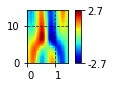

In [42]:
fundamental_windows[0][0].plot()

In [54]:
t0ad=time.time_ns()/10**9

oc1 = orb.OrbitCover(large_patch,
                     defect[:1],
                     defect_thresholds[:1],
                     periodicity=(False, True),
                     replacement=False,
                     min_overlap = 1,
                     coordinate_map=parallelipiped_map
                    )
# oc1.mask = np.ones(oc1.padded_orbit.shape, dtype=bool)
oc1 = orb.cover(oc1, verbose=True)
t1ad=time.time_ns()/10**9
print('\nL2 metric covering took {:.2f} seconds to complete'.format(t1ad-t0ad))

----------
L2 metric covering took 141.61 seconds to complete


In [56]:
test =oc1.map()

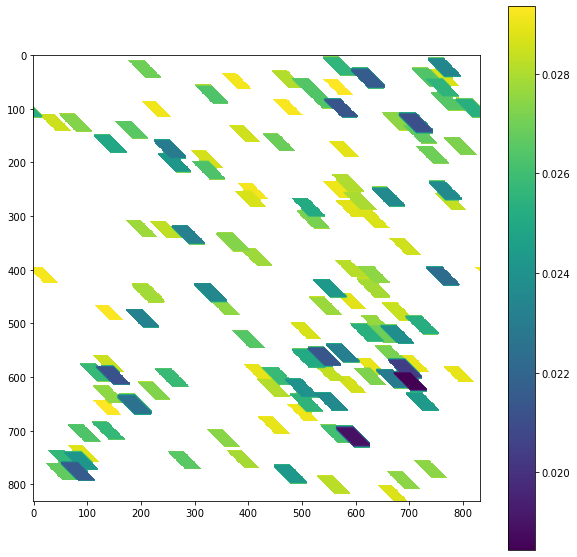

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(test[0])
plt.colorbar()
plt.show()

.This type of manipulation seemed quite hard, so instead I implemented a "coordinate mapping" method. By providing a function as via the keyword argument ```coordinate_map```, any function that can be applied to an array representing the (integer lattice) positions within the cube can be used. Then, once mapped, the coordinates of the mapped shape are checked for validity before
being used in scoring. 

This not only allows the use of parallelograms but also partial subdomains of these parallelograms, and other arbitrarily complex shapes. This is demonstrated below. This comes with a price, of course, which is the computation time. 

In [ ]:
def catmap(coordinates, **kwargs):
    # A homage to Arnold, Predrag Cvitanovic and Han Liang.  
    return np.concatenate(tuple(coord[np.where(dat.state==0)].reshape(1,-1) for coord in coordinates))
